# Prediction of demand per hour (in 2017)


In [36]:
import pandas as pd
import datetime as dt
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [37]:
#Importing the cleaned dataset
rides_data = pd.read_csv('Boston_2017_Cleaned_Data.csv')
rides_data['start_time'] = pd.to_datetime(rides_data['start_time'], errors='coerce')
rides_data

,Unnamed: 0,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,user_type
0,0,2017-01-01 00:06:58,2017-01-01 00:12:49,67,139,MIT at Mass Ave / Amherst St,Dana Park,644,Subscriber
1,1,2017-01-01 00:13:16,2017-01-01 00:28:07,36,10,Boston Public Library - 700 Boylston St.,B.U. Central - 725 Comm. Ave.,230,Subscriber
2,2,2017-01-01 00:16:17,2017-01-01 00:44:10,36,9,Boston Public Library - 700 Boylston St.,Agganis Arena - 925 Comm Ave.,980,Customer
3,3,2017-01-01 00:21:22,2017-01-01 00:33:50,46,19,Christian Science Plaza,Buswell St. at Park Dr.,1834,Subscriber
4,4,2017-01-01 00:30:06,2017-01-01 00:40:28,10,8,B.U. Central - 725 Comm. Ave.,Union Square - Brighton Ave. at Cambridge St.,230,Subscriber
...,...,...,...,...,...,...,...,...,...
1313751,1313769,2017-12-31 23:46:18,2017-12-31 23:50:27,117,141,Binney St / Sixth St,Kendall Street,1846,Subscriber
1313752,1313770,2017-12-29 16:11:56,2017-12-29 16:16:18,54,42,Tremont St at West St,Boylston St at Arlington St TEMPORARY WINTER L...,2,Subscriber
1313753,1313771,2017-12-30 08:09:44,2017-12-30 08:26:08,54,58,Tremont St at West St,Beacon St at Arlington St,1534,Subscriber
1313754,1313772,2017-12-30 12:20:01,2017-12-30 12:49:12,54,46,Tremont St at West St,Christian Science Plaza - Massachusetts Ave at...,1978,Subscriber


In [38]:
rides_data['hour'] = rides_data['start_time'].dt.floor('h')
rides_data = rides_data[["start_time", "hour"]]
rides_data


,start_time,hour
0,2017-01-01 00:06:58,2017-01-01 00:00:00
1,2017-01-01 00:13:16,2017-01-01 00:00:00
2,2017-01-01 00:16:17,2017-01-01 00:00:00
3,2017-01-01 00:21:22,2017-01-01 00:00:00
4,2017-01-01 00:30:06,2017-01-01 00:00:00
...,...,...
1313751,2017-12-31 23:46:18,2017-12-31 23:00:00
1313752,2017-12-29 16:11:56,2017-12-29 16:00:00
1313753,2017-12-30 08:09:44,2017-12-30 08:00:00
1313754,2017-12-30 12:20:01,2017-12-30 12:00:00


In [39]:
rides_data = rides_data.groupby("hour").count()
rides_data = rides_data.rename(columns={"start_time": "rides_counted"})
rides_data


,rides_counted
hour,
2017-01-01 00:00:00,13
2017-01-01 01:00:00,7
2017-01-01 02:00:00,4
2017-01-01 03:00:00,2
2017-01-01 04:00:00,6
...,...
2017-12-31 19:00:00,6
2017-12-31 20:00:00,5
2017-12-31 21:00:00,3


## WEATHER DATA


In [40]:
import statistics

weather_data = pd.read_csv("weather_2017_data_cleaned.csv", parse_dates=["date_time"])
display(weather_data)

#Drop the unnecssary indexing column 'Unnamed: 0' and replace null values with values from prior rows to keep data for every hour in 2017
weather_data = weather_data.drop('Unnamed: 0',axis=1)
list(weather_data.columns)
weather_data

,Unnamed: 0,date_time,max_temp,min_temp,precip
0,17520,2017-01-01 01:00:00,4.4,4.4,0.0
1,17521,2017-01-01 02:00:00,5.0,5.0,1.0
2,17522,2017-01-01 03:00:00,5.0,5.0,1.0
3,17523,2017-01-01 04:00:00,5.0,4.4,1.0
4,17524,2017-01-01 05:00:00,4.4,4.4,1.0
...,...,...,...,...,...
8755,26298,2017-12-31 19:00:00,-11.1,-11.1,0.0
8756,26299,2017-12-31 20:00:00,-10.6,-10.6,0.0
8757,26300,2017-12-31 21:00:00,-11.1,-11.1,0.0
8758,26301,2017-12-31 22:00:00,-11.7,-11.7,0.0


,date_time,max_temp,min_temp,precip
0,2017-01-01 01:00:00,4.4,4.4,0.0
1,2017-01-01 02:00:00,5.0,5.0,1.0
2,2017-01-01 03:00:00,5.0,5.0,1.0
3,2017-01-01 04:00:00,5.0,4.4,1.0
4,2017-01-01 05:00:00,4.4,4.4,1.0
...,...,...,...,...
8755,2017-12-31 19:00:00,-11.1,-11.1,0.0
8756,2017-12-31 20:00:00,-10.6,-10.6,0.0
8757,2017-12-31 21:00:00,-11.1,-11.1,0.0
8758,2017-12-31 22:00:00,-11.7,-11.7,0.0


In [41]:
#To deal with duplicates and missing hours due to rounded timestamps, a column with the correct date and timestamps for 2017 is created.
dates = weather_data.iloc[0]['date_time']

list_dates = []

list_dates.append(dates-dt.timedelta(hours=1))

for x in range(len(weather_data.date_time)):
    list_dates.append(dates+dt.timedelta(hours=x))

In [42]:
#Assigning the list of correct dates to the column 'date_time' and sorting for "date_time" to deal with any unsorted or missorted data.
weather_data['date_time'] = pd.Series(list_dates)
weather_data = weather_data.sort_values("date_time")
weather_data

,date_time,max_temp,min_temp,precip
0,2017-01-01 00:00:00,4.4,4.4,0.0
1,2017-01-01 01:00:00,5.0,5.0,1.0
2,2017-01-01 02:00:00,5.0,5.0,1.0
3,2017-01-01 03:00:00,5.0,4.4,1.0
4,2017-01-01 04:00:00,4.4,4.4,1.0
...,...,...,...,...
8755,2017-12-31 19:00:00,-11.1,-11.1,0.0
8756,2017-12-31 20:00:00,-10.6,-10.6,0.0
8757,2017-12-31 21:00:00,-11.1,-11.1,0.0
8758,2017-12-31 22:00:00,-11.7,-11.7,0.0


In [43]:
weather_data = weather_data.set_index('date_time')
weather_data

,max_temp,min_temp,precip
date_time,,,
2017-01-01 00:00:00,4.4,4.4,0.0
2017-01-01 01:00:00,5.0,5.0,1.0
2017-01-01 02:00:00,5.0,5.0,1.0
2017-01-01 03:00:00,5.0,4.4,1.0
2017-01-01 04:00:00,4.4,4.4,1.0
...,...,...,...
2017-12-31 19:00:00,-11.1,-11.1,0.0
2017-12-31 20:00:00,-10.6,-10.6,0.0
2017-12-31 21:00:00,-11.1,-11.1,0.0


# Join the datasets representing the rides and the weather

In [44]:
data = weather_data.join(rides_data, how="outer")
data["rides_counted"] = data["rides_counted"].fillna(0)
data

,max_temp,min_temp,precip,rides_counted
2017-01-01 00:00:00,4.4,4.4,0.0,13.0
2017-01-01 01:00:00,5.0,5.0,1.0,7.0
2017-01-01 02:00:00,5.0,5.0,1.0,4.0
2017-01-01 03:00:00,5.0,4.4,1.0,2.0
2017-01-01 04:00:00,4.4,4.4,1.0,6.0
...,...,...,...,...
2017-12-31 19:00:00,-11.1,-11.1,0.0,6.0
2017-12-31 20:00:00,-10.6,-10.6,0.0,5.0
2017-12-31 21:00:00,-11.1,-11.1,0.0,3.0
2017-12-31 22:00:00,-11.7,-11.7,0.0,7.0


In [45]:
data.index.name = "date_time"
data['weekday'] = data.index.dayofweek
data['month'] = data.index.month
data['hour'] = data.index.hour
data

,max_temp,min_temp,precip,rides_counted,weekday,month,hour
date_time,,,,,,,
2017-01-01 00:00:00,4.4,4.4,0.0,13.0,6,1,0
2017-01-01 01:00:00,5.0,5.0,1.0,7.0,6,1,1
2017-01-01 02:00:00,5.0,5.0,1.0,4.0,6,1,2
2017-01-01 03:00:00,5.0,4.4,1.0,2.0,6,1,3
2017-01-01 04:00:00,4.4,4.4,1.0,6.0,6,1,4
...,...,...,...,...,...,...,...
2017-12-31 19:00:00,-11.1,-11.1,0.0,6.0,6,12,19
2017-12-31 20:00:00,-10.6,-10.6,0.0,5.0,6,12,20
2017-12-31 21:00:00,-11.1,-11.1,0.0,3.0,6,12,21


### add is_holiday_or_weekend column


In [46]:
from datetime import date as date

df_holidays = pd.DataFrame(
    {'month':[1,1,2,5,7,9,10,11,11,12],
     'day':[1,16,20,29,4,4,9,12,23,25]})

holidays=[]

for i in range(len(df_holidays)):
    holidays.append(date(2017,df_holidays.iloc[i]['month'],df_holidays.iloc[i]['day']))
    
holidays

[datetime.date(2017, 1, 1),
 datetime.date(2017, 1, 16),
 datetime.date(2017, 2, 20),
 datetime.date(2017, 5, 29),
 datetime.date(2017, 7, 4),
 datetime.date(2017, 9, 4),
 datetime.date(2017, 10, 9),
 datetime.date(2017, 11, 12),
 datetime.date(2017, 11, 23),
 datetime.date(2017, 12, 25)]

In [47]:
holiday = np.isin(data.index.date, holidays)
weekday = data["weekday"] > 5
data["holiday_or_weekend"] = holiday | weekday
data

,max_temp,min_temp,precip,rides_counted,weekday,month,hour,holiday_or_weekend
date_time,,,,,,,,
2017-01-01 00:00:00,4.4,4.4,0.0,13.0,6,1,0,True
2017-01-01 01:00:00,5.0,5.0,1.0,7.0,6,1,1,True
2017-01-01 02:00:00,5.0,5.0,1.0,4.0,6,1,2,True
2017-01-01 03:00:00,5.0,4.4,1.0,2.0,6,1,3,True
2017-01-01 04:00:00,4.4,4.4,1.0,6.0,6,1,4,True
...,...,...,...,...,...,...,...,...
2017-12-31 19:00:00,-11.1,-11.1,0.0,6.0,6,12,19,True
2017-12-31 20:00:00,-10.6,-10.6,0.0,5.0,6,12,20,True
2017-12-31 21:00:00,-11.1,-11.1,0.0,3.0,6,12,21,True


# Prediction Models


## ARIMA


In [48]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12,10

In [49]:
arimaData = data
arimaData = pd.DataFrame(arimaData["rides_counted"])
#arimaData.index.name = "date_time"

# define train and test data for the arima model. Training data are the values for the 
trainArima = arimaData.head(int((len(arimaData)/4)*3))
testArima = arimaData.tail(int(len(arimaData)/4))

display(trainArima)
display(testArima)

,rides_counted
date_time,
2017-01-01 00:00:00,13.0
2017-01-01 01:00:00,7.0
2017-01-01 02:00:00,4.0
2017-01-01 03:00:00,2.0
2017-01-01 04:00:00,6.0
...,...
2017-10-01 13:00:00,397.0
2017-10-01 14:00:00,413.0
2017-10-01 15:00:00,446.0


,rides_counted
date_time,
2017-10-01 18:00:00,398.0
2017-10-01 19:00:00,231.0
2017-10-01 20:00:00,151.0
2017-10-01 21:00:00,133.0
2017-10-01 22:00:00,79.0
...,...
2017-12-31 19:00:00,6.0
2017-12-31 20:00:00,5.0
2017-12-31 21:00:00,3.0


<AxesSubplot: xlabel='date_time'>

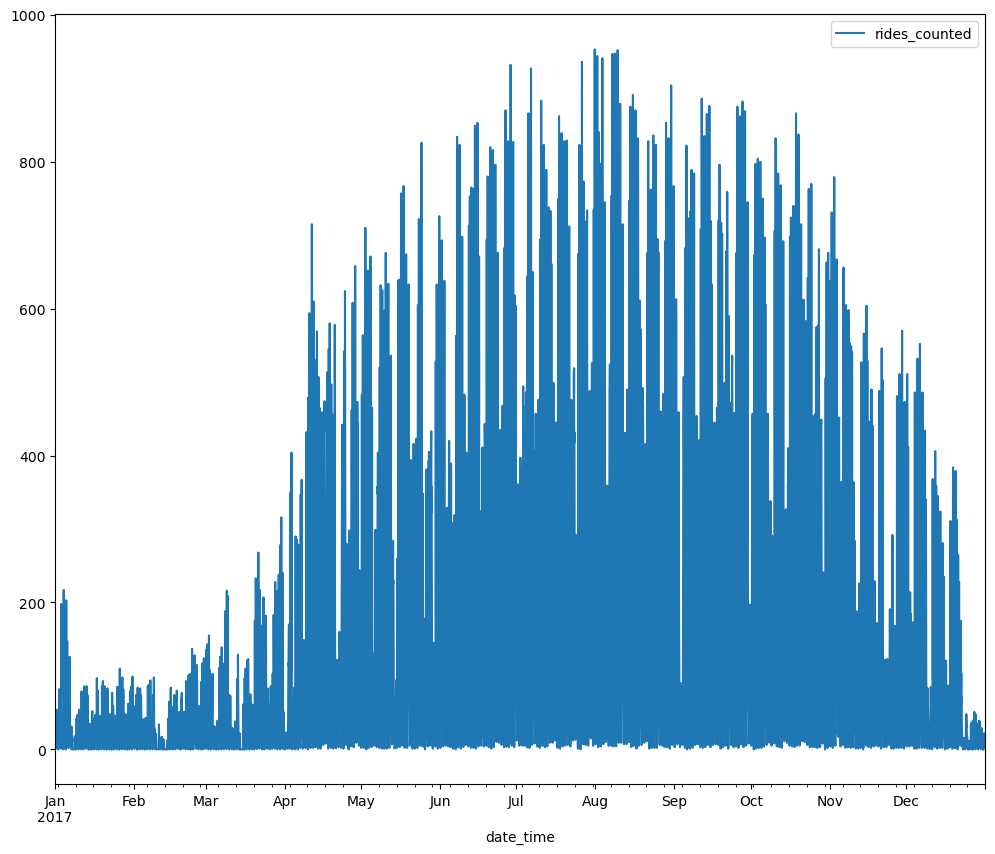

In [50]:
arimaData.plot(y="rides_counted")

In [51]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):

    # Determing rolling statistics (including 24 hours a day times 7 days a week)
    rolmean = timeseries.rolling(window=168).mean()
    rolstd = timeseries.rolling(window=168).std()

    # Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='orange', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Dickey-Fuller test:
    print('Dickey-Fuller Test:\n')
    df_DiFu_Test = adfuller(timeseries)
    df_Test_Output = pd.Series(df_DiFu_Test[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in df_DiFu_Test[4].items():
        df_Test_Output['Critical Value (%s)' % key] = value
    print(df_Test_Output)

In [52]:
df_pvalues = pd.DataFrame([], columns=["p-values for...","value"])

In [53]:
adfuller(arimaData['rides_counted'])

(-5.816592579042559,
 4.2782277442021324e-07,
 37,
 8722,
 {'1%': -3.431099968539641,
  '5%': -2.86187143613454,
  '10%': -2.5669464184887825},
 94428.21803278825)

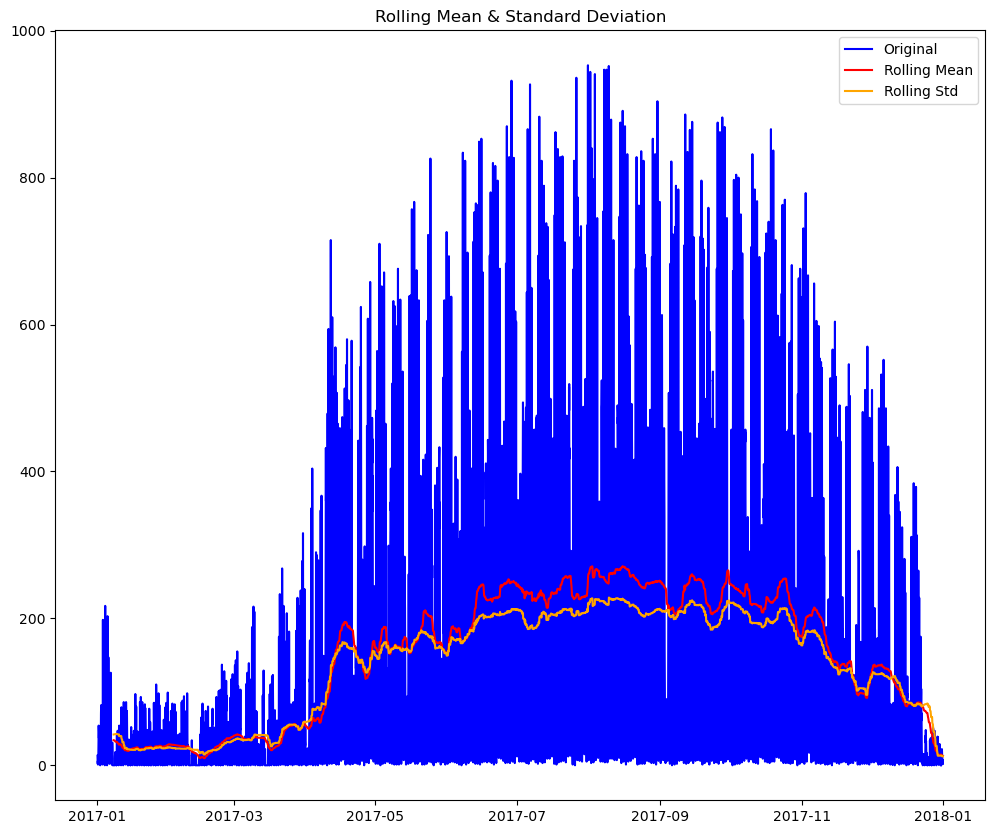

Dickey-Fuller Test:

Test Statistic                -5.816593e+00
p-value                        4.278228e-07
#Lags Used                     3.700000e+01
Number of Observations Used    8.722000e+03
Critical Value (1%)           -3.431100e+00
Critical Value (5%)           -2.861871e+00
Critical Value (10%)          -2.566946e+00
dtype: float64


,p-values for...,value
0,arimaData,4.278228e-07


In [54]:
test_stationarity(arimaData['rides_counted'])

df_pvalues.loc[int(len(df_pvalues))] = ["arimaData", adfuller(arimaData['rides_counted'])[1]]
display(df_pvalues)

p value is basically 0, no matter what size of rolling mean/std/number of years in data, so this data seems to be stationary. Overall (yearly) trend does seem to be 0.


### Moving average


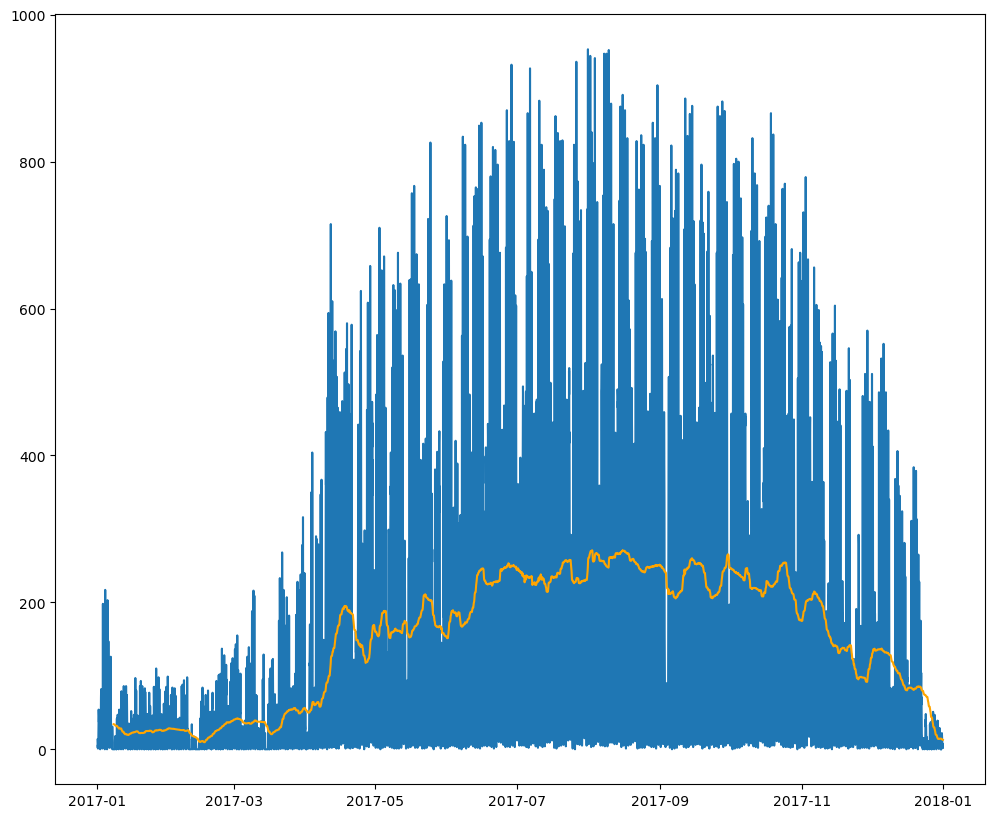

In [55]:
moving_avg = arimaData.rolling(168).mean()
plt.plot(arimaData)
plt.plot(moving_avg, color='orange')

In [56]:
moving_avg_diff = arimaData - moving_avg
moving_avg_diff.dropna(inplace=True)
moving_avg_diff

,rides_counted
date_time,
2017-01-07 23:00:00,-34.142857
2017-01-08 00:00:00,-34.065476
2017-01-08 01:00:00,-34.023810
2017-01-08 02:00:00,-34.000000
2017-01-08 03:00:00,-33.988095
...,...
2017-12-31 19:00:00,-7.005952
2017-12-31 20:00:00,-7.970238
2017-12-31 21:00:00,-9.886905


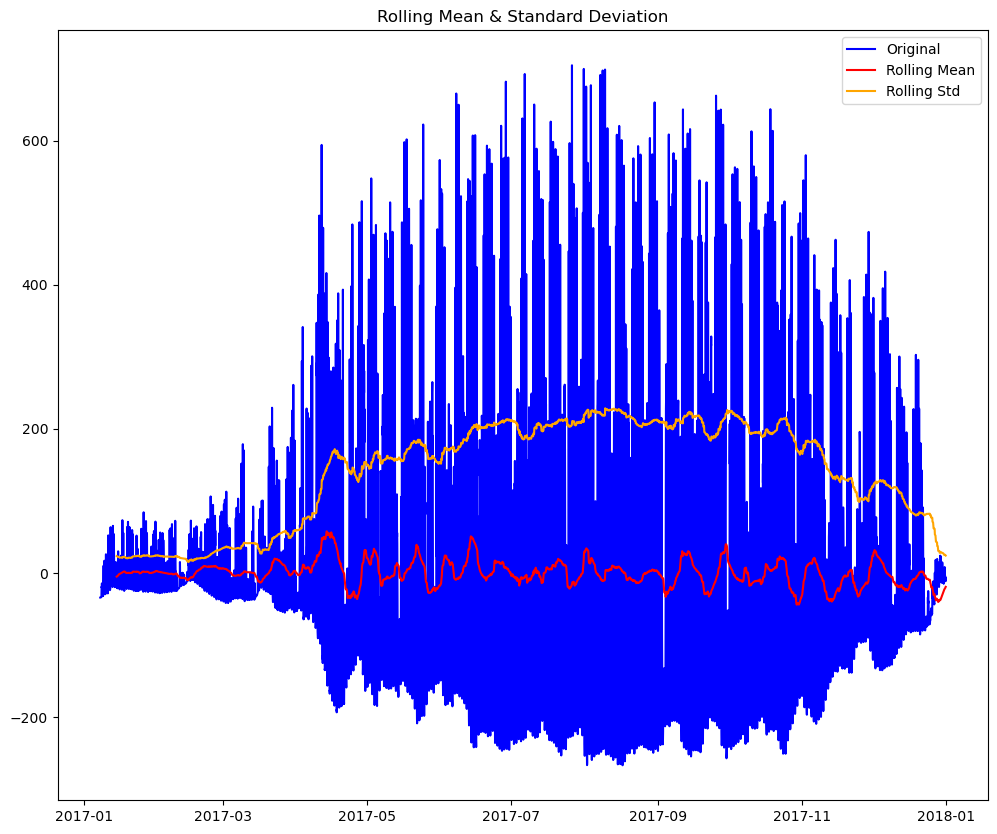

Dickey-Fuller Test:

Test Statistic                -1.475992e+01
p-value                        2.411190e-27
#Lags Used                     3.700000e+01
Number of Observations Used    8.555000e+03
Critical Value (1%)           -3.431115e+00
Critical Value (5%)           -2.861878e+00
Critical Value (10%)          -2.566950e+00
dtype: float64


,p-values for...,value
0,arimaData,4.278228e-07
1,moving_avg_diff,2.411190e-27


In [57]:
test_stationarity(moving_avg_diff)

df_pvalues.loc[int(len(df_pvalues))] = ["moving_avg_diff", adfuller(moving_avg_diff['rides_counted'])[1]]
display(df_pvalues)

test statistic is now even lower, leading to a p-value of 0


### Weighted moving average


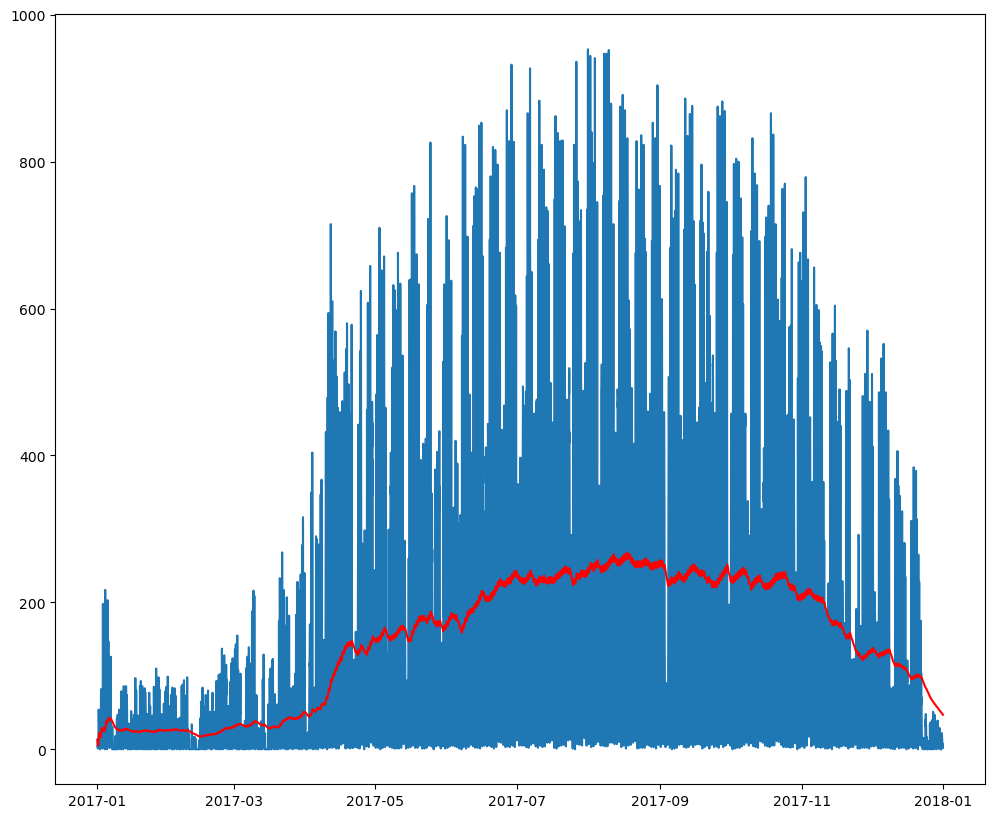

In [58]:
# Provides exponential weighted functions
expwighted_avg = arimaData.ewm(halflife=168).mean()
plt.plot(arimaData)
plt.plot(expwighted_avg, color='red')


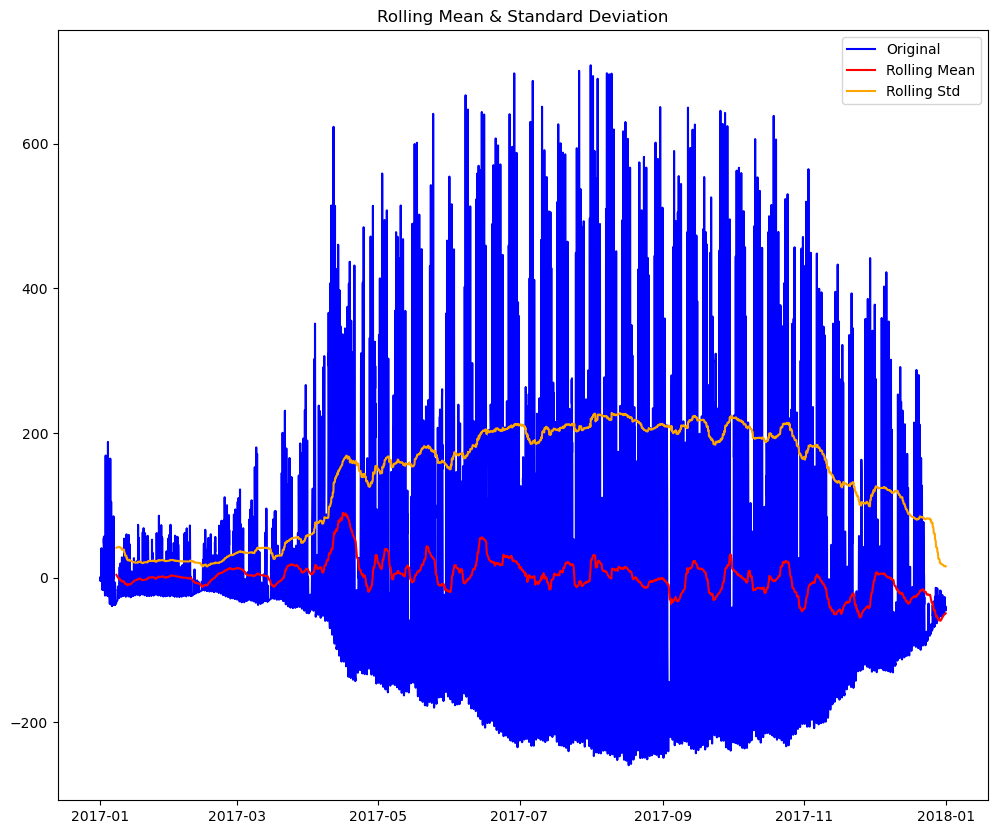

Dickey-Fuller Test:

Test Statistic                -1.381394e+01
p-value                        8.134581e-26
#Lags Used                     3.700000e+01
Number of Observations Used    8.722000e+03
Critical Value (1%)           -3.431100e+00
Critical Value (5%)           -2.861871e+00
Critical Value (10%)          -2.566946e+00
dtype: float64


,p-values for...,value
0,arimaData,4.278228e-07
1,moving_avg_diff,2.411190e-27
2,ewma_diff,8.134581e-26


In [59]:
ewma_diff = arimaData - expwighted_avg

test_stationarity(ewma_diff)

df_pvalues.loc[int(len(df_pvalues))] = ["ewma_diff", adfuller(ewma_diff['rides_counted'])[1]]
display(df_pvalues)

results are slightly worse than "normal" moving average, but p value is still 0


### differencing


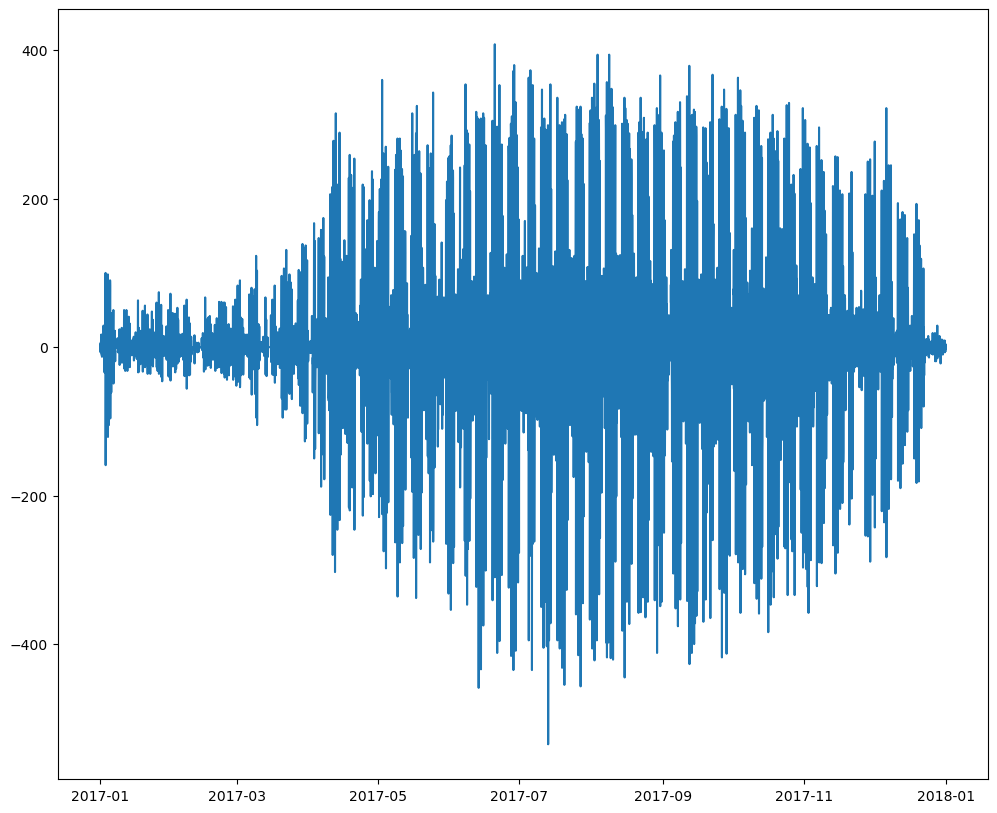

In [60]:
diff = arimaData - arimaData.shift()
plt.plot(diff)


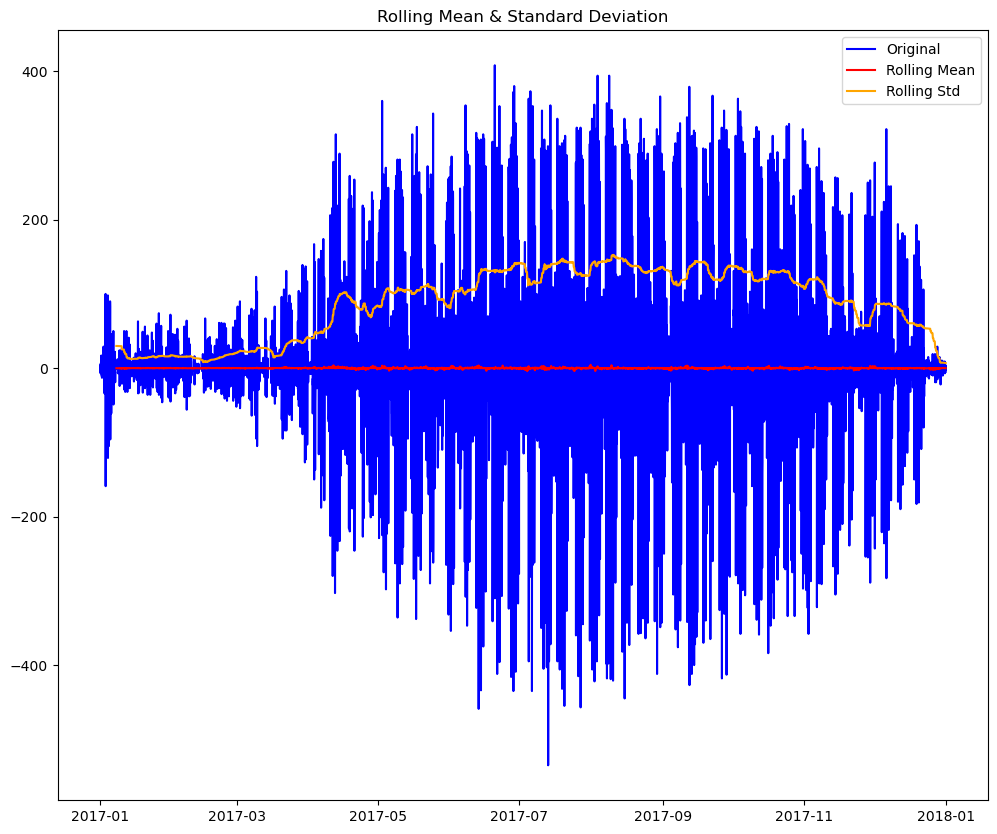

Dickey-Fuller Test:

Test Statistic                -1.830462e+01
p-value                        2.282782e-30
#Lags Used                     3.700000e+01
Number of Observations Used    8.721000e+03
Critical Value (1%)           -3.431100e+00
Critical Value (5%)           -2.861871e+00
Critical Value (10%)          -2.566946e+00
dtype: float64


,p-values for...,value
0,arimaData,4.278228e-07
1,moving_avg_diff,2.411190e-27
2,ewma_diff,8.134581e-26
3,diff,2.282782e-30


In [61]:
diff.dropna(inplace=True)
test_stationarity(diff)

df_pvalues.loc[int(len(df_pvalues))] = ["diff", adfuller(diff['rides_counted'])[1]]
display(df_pvalues)

best result so far


### Decomposing

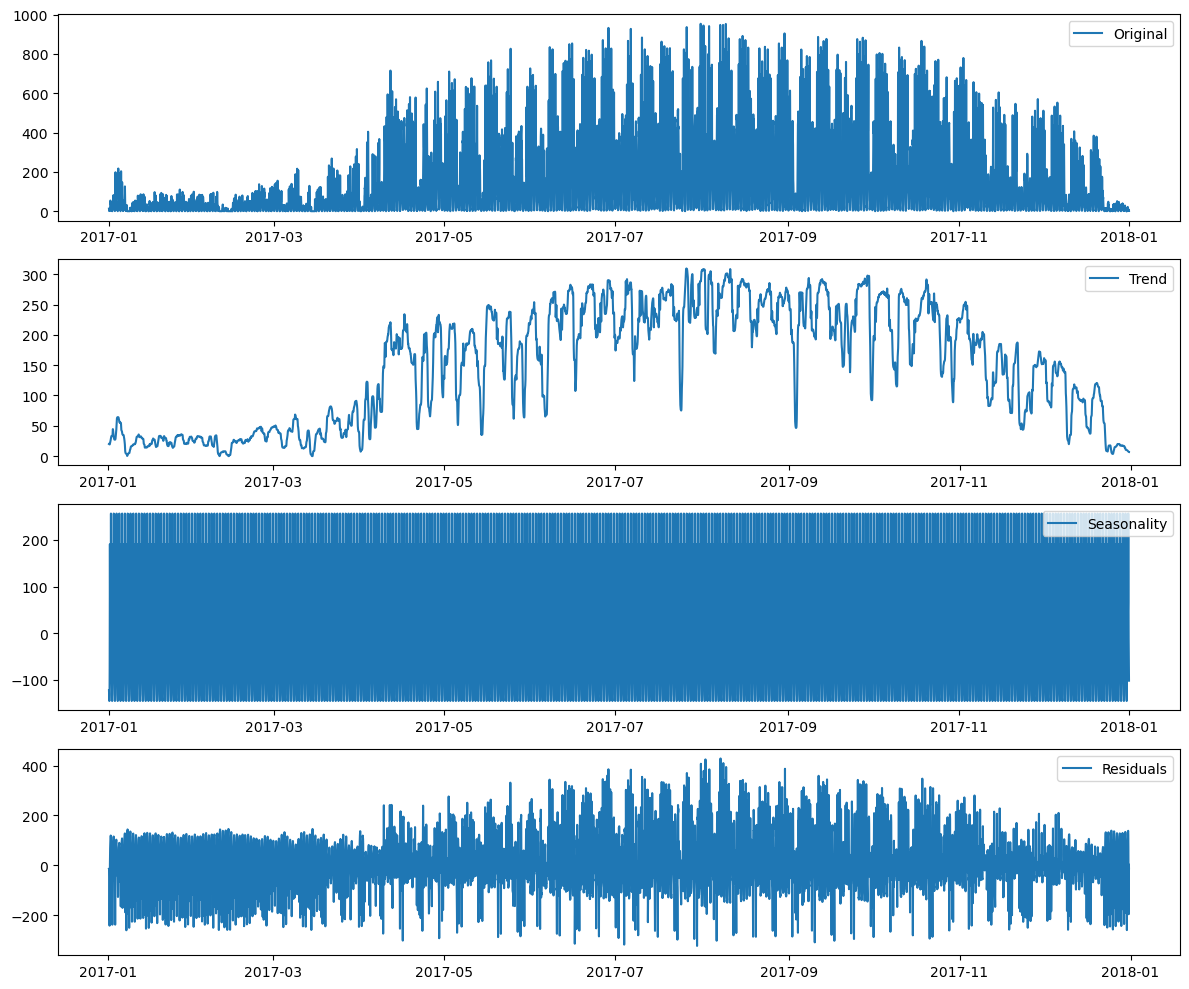

In [62]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Seasonal decomposition using moving averages
decomposition = seasonal_decompose(arimaData)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(arimaData, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

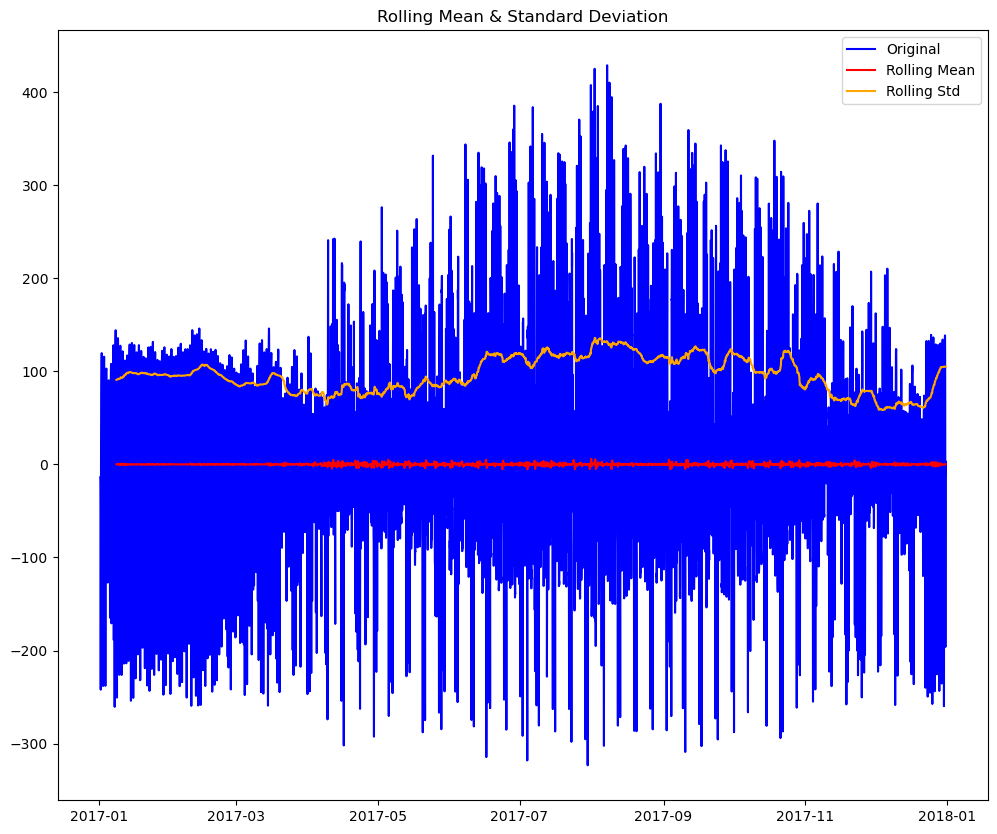

Dickey-Fuller Test:

Test Statistic                  -28.734835
p-value                           0.000000
#Lags Used                       37.000000
Number of Observations Used    8698.000000
Critical Value (1%)              -3.431102
Critical Value (5%)              -2.861872
Critical Value (10%)             -2.566947
dtype: float64


,p-values for...,value
0,arimaData,4.278228e-07
1,moving_avg_diff,2.411190e-27
2,ewma_diff,8.134581e-26
3,diff,2.282782e-30
4,decomposed,0.000000e+00


In [63]:
decompose = residual
decompose.dropna(inplace=True)
test_stationarity(decompose)

df_pvalues.loc[int(len(df_pvalues))] = ["decomposed", adfuller(decompose)[1]]
display(df_pvalues)

The Dickey-Fuller test statistic is significantly lower than the 1% critical value. So the decomposed dataset is very close to stationary.

Decomposing leads to the overall best result regarding the Dickey-Fuller Test. Therefore, the decomposed values will be used for the ARIMA model


In [64]:
df_pvalues = df_pvalues.drop_duplicates().sort_values('value')
df_pvalues

,p-values for...,value
4,decomposed,0.000000e+00
3,diff,2.282782e-30
1,moving_avg_diff,2.411190e-27
2,ewma_diff,8.134581e-26
0,arimaData,4.278228e-07


### Auto Correlation Function (ACF) and Partial AutoCorrelation Function (PACF) to determine p and q of the ARIMA model


In [65]:
from statsmodels.tsa.stattools import acf, pacf

In [66]:
lag_acf = acf(diff, nlags=3)
lag_pacf = pacf(diff, nlags=3, method='ols')

Text(0.5, 1.0, 'Autocorrelation Function')

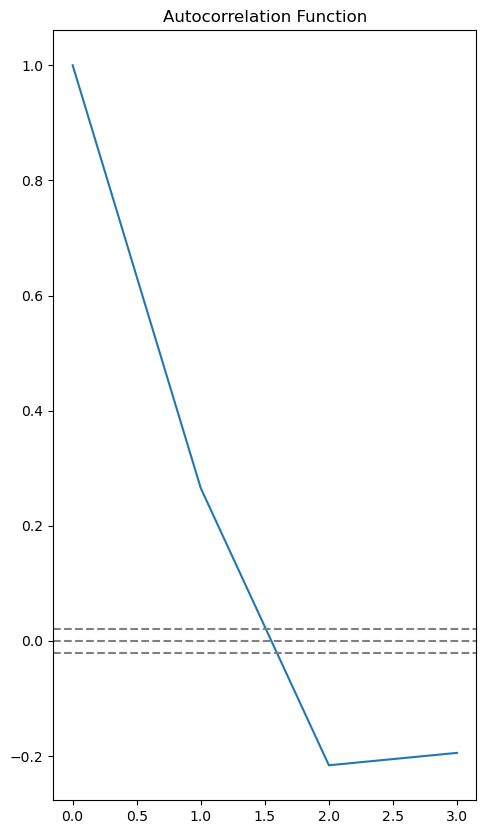

In [67]:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(diff)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

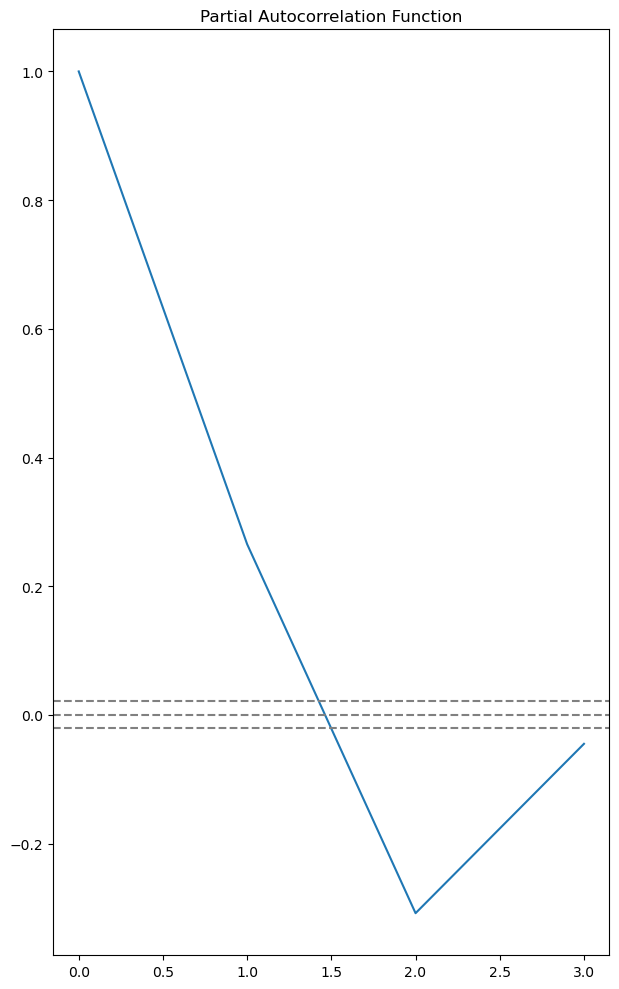

In [68]:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(diff)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

The lag value where the ACF chart crosses the upper confidence interval for the first time is ca. 1.5. Therefore, q is set to 2.

The lag value where the PACF chart crosses the upper confidence interval for the first time is ca. 1.4. Therefore, p is set to 2.


## Create the ARIMA model from the ARIMA data and the values resulting from the ACF/PACF section


In [69]:
from statsmodels.tsa.arima.model import ARIMA

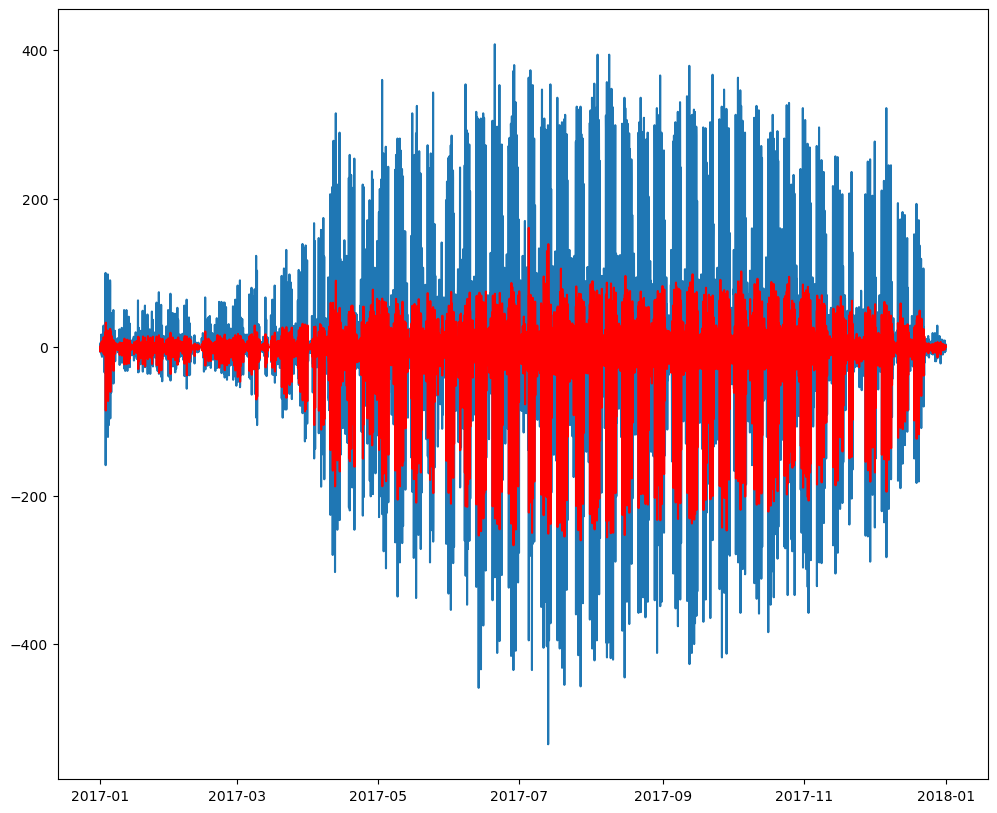

In [72]:
warnings.filterwarnings("ignore")

model = ARIMA(diff, order=(2, 1, 2))
model_fit = model.fit()

plt.plot(diff)
plt.plot(model_fit.fittedvalues, color='red')
#plt.plot('RSS: %.4f'% sum((model_fit.fittedvalues - diff)**2))

In [73]:
display(model_fit.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          rides_counted   No. Observations:                 8759
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -51797.892
Date:                Mon, 30 Jan 2023   AIC                         103605.784
Time:                        05:15:32   BIC                         103641.173
Sample:                    01-01-2017   HQIC                        103617.842
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5447      0.039     13.990      0.000       0.468       0.621
ar.L2         -0.3577      0.013    -28.066      0.000      -0.383      -0.333
ma.L1         -1.2196      0.040    -30.681      0.000      -1.298      -1.142
ma.L2          0.2197      0.040      5.455      0.000       0.141       0.299
sigma2      8018.1844    139.315     57.554      0.000    7745.132    8291.237
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):             10942.55
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):               4.69   Skew:                            -0.39
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### ARIMA Forecasting


In [74]:
decomposition = seasonal_decompose(testArima)
trend = decomposition.trend
seasonal = decomposition.seasonal


In [75]:
validation_df = pd.DataFrame(trend)

# forecast 2018 data only
validation_df["residual_prediction"] = model_fit.forecast()
validation_df["seasonal"] = seasonal

# add back seasonal and trend to compare prediction to actual values
validation_df["prediction"] = validation_df["trend"] + validation_df["seasonal"] + validation_df["residual_prediction"]
validation_df.dropna()


,trend,residual_prediction,seasonal,prediction
date_time,,,,


In [77]:
testArima["prediction"] = validation_df["prediction"]
# set negative predictions to 0, since demand can't be negative
testArima["prediction"][testArima["prediction"] < 0] = 0
# round prediction to nearest integer, since bikes can't be half rented (does not affect error significantly)
testArima = testArima.round({"prediction": 0})
testArima["prediction_abs_error"] = abs(testArima["prediction"] - testArima["rides_counted"])
# the first and last 12 values are not predicted
testArima.dropna()


,rides_counted,prediction,prediction_abs_error
date_time,,,


#### calculate prediction errors

Text(0.5, 1.0, 'absolute error in forecasting')

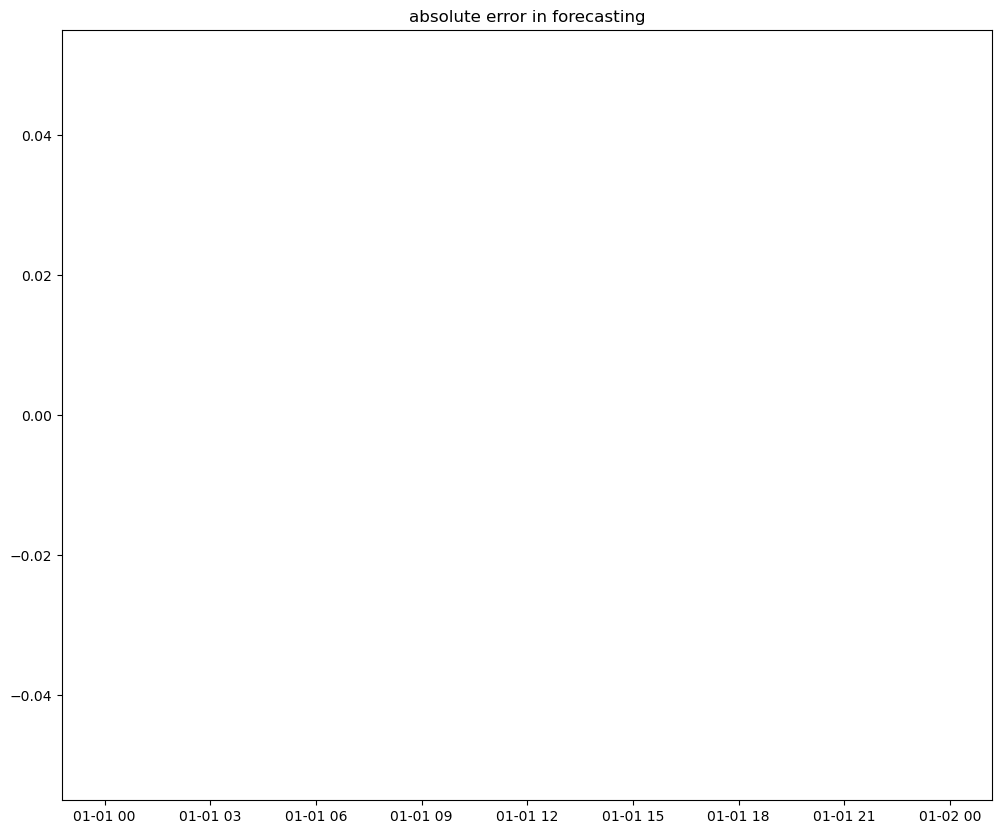

In [78]:
plt.plot(testArima["prediction_abs_error"])
plt.title("absolute error in forecasting")


In [80]:
print("mean squared error: " +
      str((testArima["prediction_abs_error"]**2).mean()))
print("mean absolute error: " +
      str(testArima["prediction_abs_error"].mean()))


mean squared error: nan
mean absolute error: nan


In [81]:
testArima["rides_counted"].mean()


146.35570776255707

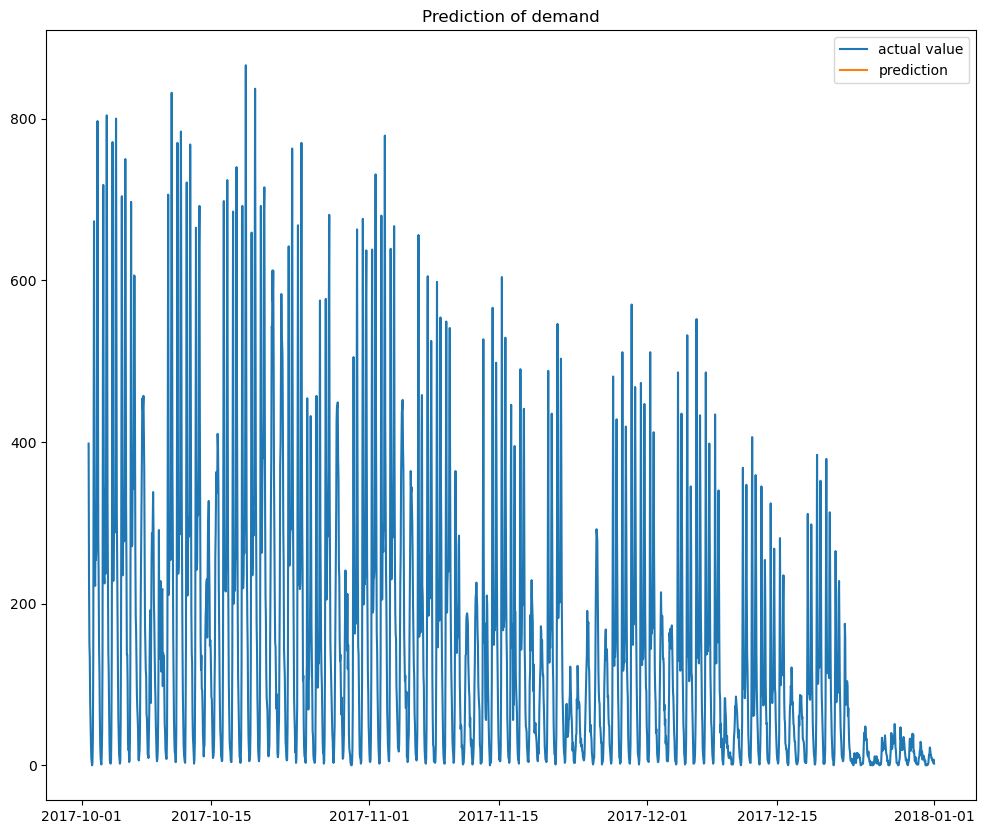

In [82]:
plt.plot(testArima["rides_counted"], label="actual value")
plt.plot(testArima["prediction"], label="prediction")
plt.title("Prediction of demand")
plt.legend()


## Random Forest


Remove target 'rides_counted' to retrieve the features


In [85]:
data_random_forest = data

In [87]:
target = data_random_forest['rides_counted']
features = data_random_forest.drop(['rides_counted'], axis=1)
feature_list = list(features.columns)
features


,max_temp,min_temp,precip,weekday,month,hour,holiday_or_weekend
date_time,,,,,,,
2017-01-01 00:00:00,4.4,4.4,0.0,6,1,0,True
2017-01-01 01:00:00,5.0,5.0,1.0,6,1,1,True
2017-01-01 02:00:00,5.0,5.0,1.0,6,1,2,True
2017-01-01 03:00:00,5.0,4.4,1.0,6,1,3,True
2017-01-01 04:00:00,4.4,4.4,1.0,6,1,4,True
...,...,...,...,...,...,...,...
2017-12-31 19:00:00,-11.1,-11.1,0.0,6,12,19,True
2017-12-31 20:00:00,-10.6,-10.6,0.0,6,12,20,True
2017-12-31 21:00:00,-11.1,-11.1,0.0,6,12,21,True


Split the data sets


In [88]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(
    features, target,  random_state=0)


In [89]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)


Training Features Shape: (6570, 7)
Training Labels Shape: (6570,)
Testing Features Shape: (2190, 7)
Testing Labels Shape: (2190,)


Train Model


In [90]:
from sklearn.ensemble import RandomForestRegressor

# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators=1000, random_state=42)

# Train the model on training data
rf.fit(train_features, train_labels)


RandomForestRegressor(n_estimators=1000, random_state=42)

In [91]:
predictions = rf.predict(test_features)
predictions[predictions < 0]


array([], dtype=float64)

In [92]:
errors = abs(predictions - test_labels)
print('Mean Absolute Error:', round(np.mean(errors), 2), ' rented bikes.')


Mean Absolute Error: 30.71  rented bikes.


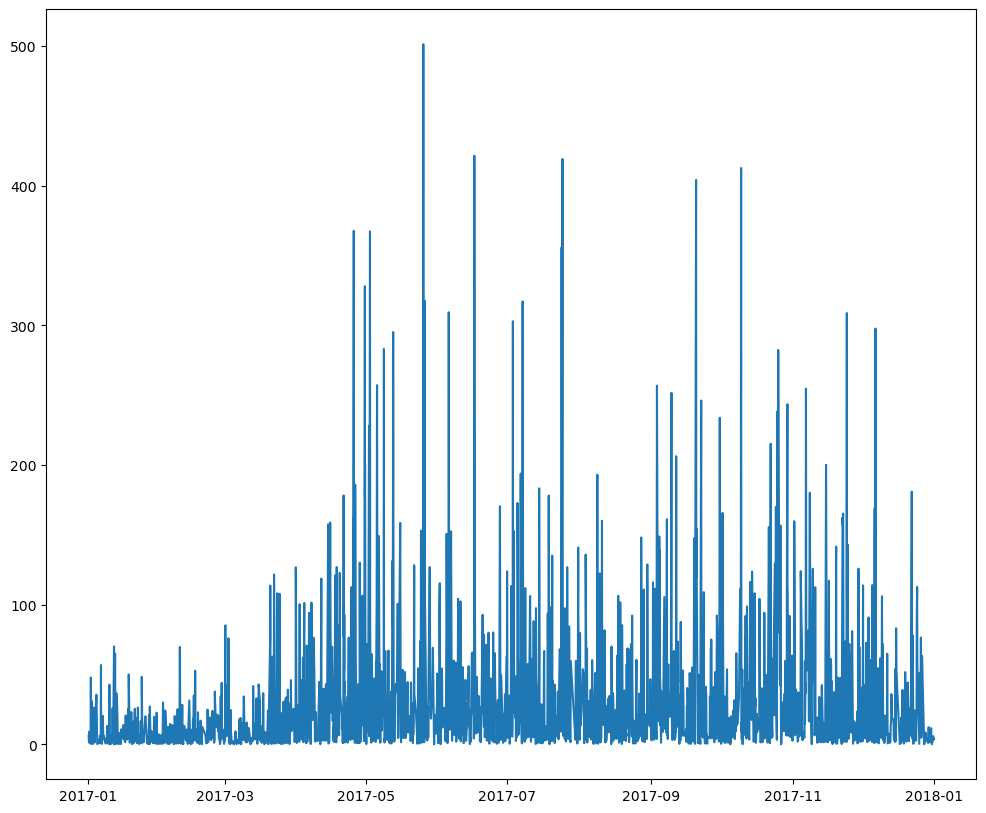

In [93]:
errors = errors.sort_index()
plt.plot(errors)


## Polynomial regression


In [95]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression


only include data from 2018


In [97]:
data_polynomial_regression = data


Function that transforms the input features to the wanted dimension


In [98]:
def fit_and_transform_features_to_new_dimension(new_dim, features):
    poly_reg = PolynomialFeatures(degree=new_dim)
    return poly_reg.fit_transform(features)


PCA to reduce some noise before applying linear regression

In [120]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(features)
features_scaled = scaler.transform(features)
pca = PCA(n_components=1)
X_pca = pca.fit_transform(features_scaled)

In [121]:
print(pca.explained_variance_ratio_[0])

0.303600213689305


Using only one component does not supply a sufficient explained variance ratio of 95%. Using a while loop it is searched for the necessary number of components.

In [147]:
n = 0
i = 0

while i < 0.95:
    n+=1
    pca = PCA(n_components = n)
    X_pca = pca.fit_transform(features_scaled)
    i = sum(pca.explained_variance_ratio_)   
    
display('explained variance ratio: '+str(i))
display(pca)
display(X_pca)

'explained variance ratio: 0.9999430870004398'

PCA(n_components=6)

array([[ 1.44072129,  2.49040862,  1.5576001 , -0.88419454, -1.36952324,
         0.51927076],
       [ 1.86821621,  2.16228129,  3.27236766,  1.59083659, -0.11975727,
         0.50376216],
       [ 1.87454816,  2.162219  ,  3.15858747,  1.67948816, -0.12469486,
         0.50353009],
       ...,
       [ 2.78074115,  2.63501986, -1.8637484 , -0.24812239,  1.84495847,
         0.57837515],
       [ 2.86789934,  2.63156834, -1.98833072, -0.17813742,  1.85743427,
         0.57927361],
       [ 2.79340505,  2.63489528, -2.09130877, -0.07081926,  1.83508328,
         0.577911  ]])

Using six components, an explained variance ratio of more than 95% is reached. Therefore, six components are used in the following regression. 

new train-test split as we have the new variables with the pca 

In [148]:
train_features, test_features, train_labels, test_labels = train_test_split(X_pca, target,  random_state=0)

Function that creates a new regression model and fits it with input features


In [149]:
def create_and_fit_model(test_features, test_labels):
    
    # normalization is redundant as features are already normalized for PCA, but to be on the safe side we normalize once more
    lin_reg_2 = LinearRegression(normalize=True)
    lin_reg_2.fit(test_features, test_labels)
    
    return lin_reg_2


Function to compute mean average error for a regression model


In [150]:
def compute_mean_average_error(polynomial_regression, test_features, test_labels):
    
    predictions = polynomial_regression.predict(test_features)
    abs_error = abs(predictions - test_labels)
    
    return round(np.mean(abs_error), 2)


Compute mean average error for degree one to ten for test and training data set.


In [ ]:
# Computing time rises exponentially for higher ranges.
test_errors = pd.Series([], dtype='float64')
training_errors = pd.Series([], dtype='float64')

for i in range(1, 11):
    train_features_dim_i = fit_and_transform_features_to_new_dimension(
        i, train_features)
    test_features_dim_i = fit_and_transform_features_to_new_dimension(
        i, test_features)
    regression_model_dim_i = create_and_fit_model(
        train_features_dim_i, train_labels)
    mean_avg_error_test = compute_mean_average_error(
        regression_model_dim_i, test_features_dim_i, test_labels)
    mean_avg_error_train = compute_mean_average_error(
        regression_model_dim_i, train_features_dim_i, train_labels)
    test_errors[i] = mean_avg_error_test
    training_errors[i] = mean_avg_error_train


Plot mean average error for the different degrees.


In [ ]:
plt.semilogy(range(len(training_errors)), training_errors,
             range(len(test_errors)), test_errors)
plt.legend(["Training", "Validation"])
plt.xlabel("Polynomial degree")
plt.ylabel("Mean squared error")


Show the five degrees with the lowest average error in the predction.


In [ ]:
test_errors.sort_values().head(n=5)


We take the model with degree = 2.


## Regularization


Retrieve the five highest coefficients for our features


In [ ]:
train_features_dim_4 = fit_and_transform_features_to_new_dimension(
    4, train_features)
test_features_dim_4 = fit_and_transform_features_to_new_dimension(
    4, test_features)
regression_model_dim_4 = create_and_fit_model(
    train_features_dim_4, train_labels)
sorted_index_array = np.argsort(regression_model_dim_4.coef_)
regression_model_dim_4.coef_[sorted_index_array[-5:]]


Retrieve the five lowest coeffecients for out features


In [ ]:
regression_model_dim_4.coef_[sorted_index_array[1:6]]


#### Ridge regression


Search for a good and appropriate alpha value.


In [ ]:
from sklearn.linear_model import Ridge
alphas = np.logspace(-10, 10, 100)
test_errors_l2 = pd.Series([], dtype='float64')
training_errors_l2 = pd.Series([], dtype='float64')
for alpha in alphas:
    model_L2 = Ridge(alpha=alpha, normalize=True, solver='lsqr')
    model_L2.fit(train_features_dim_4, train_labels)
    test_errors_l2[alpha] = compute_mean_average_error(
        model_L2, test_features_dim_4, test_labels)
    training_errors_l2[alpha] = compute_mean_average_error(
        model_L2, train_features_dim_4, train_labels)


Plot mean average error for the different alpha values


In [ ]:
plt.loglog(alphas, training_errors_l2, alphas, test_errors_l2)
plt.legend(["Training", "Validation"])
plt.xlabel("Regularization parameter alpha")
plt.ylabel("Mean average error L2")
plt.title("Ridge regression")

In [ ]:
print("We have the lowest mean average error of {0} for alpha = {1}".format(test_errors_l2[test_errors_l2.sort_values(
).head(n=1).index].values[0], str(test_errors_l2.sort_values().head(n=1).index)[14:19]))


Thus with the regularization we could improve our mean average error slightly.


#### Lasso regression


In [ ]:
# takes 2 minutes
from sklearn.linear_model import Lasso
alphas = np.logspace(-10, 10, 100)
test_errors_l1 = pd.Series([], dtype='float64')
training_errors_l1 = pd.Series([], dtype='float64')
for alpha in alphas:
    model_L1 = Lasso(alpha=alpha)
    model_L1.fit(train_features_dim_4, train_labels)
    test_errors_l1[alpha] = compute_mean_average_error(
        model_L1, test_features_dim_4, test_labels)
    training_errors_l1[alpha] = compute_mean_average_error(
        model_L1, train_features_dim_4, train_labels)


In [ ]:
plt.loglog(alphas, training_errors_l1, alphas, test_errors_l1)
plt.legend(["Training", "Validation"])
plt.xlabel("Regularization parameter alpha")
plt.ylabel("Mean average error L1")
plt.title("Lasso regression")


In [ ]:
print("We have the lowest mean average error of {0} for alpha = {1}".format(test_errors_l1[test_errors_l1.sort_values(
).head(n=1).index].values[0], str(test_errors_l1.sort_values().head(n=1).index)[14:19]))
